<a href="https://colab.research.google.com/github/MarshaGomez/F5-MOEA-Variations/blob/main/examples/Single_Objective_Brachistochrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Objective. Brachistochrone Problem


The Brachistochone is the famous problem to find the shape of the curve down wich a bead sliding from rest and accelerated by gravity will slip (**without friction**) from one point to another in the least time. 

"The shortest path and the shortest time"

## Base Operations

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import os
import subprocess
import torch
import sys
import torch.optim as optim
import glob

from pathlib import Path
from PIL import Image, ImageSequence
from time import sleep
from datetime import datetime, date
from math import sqrt,sin,cos, floor
from scipy.optimize import fsolve
from random import shuffle,randint,sample,random
from copy import deepcopy

### Global Values

In [ ]:
base_path = "/content/gdrive/My Drive/Brachistochrone/MOEA Project/Single-Objective"
counter = 0

date_string = date.today()
base_name = f'GD_Brach__{date_string}'
gif_dir = os.path.join(base_path, "gifs/" + base_name)
misc_runs_dir = os.path.join(base_path, "misc_runs/" + base_name)

Path(gif_dir).mkdir(parents=True, exist_ok=True)
Path(misc_runs_dir).mkdir(parents=True, exist_ok=True)

### Hyperparameters

In [ ]:
objectives = ["Short Time"]
n_dimensions = 1
n_iterations = 200
n_population = 10
n_generations = 200
n_points = 30

# Boundaries 
xl = 0 # left boundary
xr = 1 # rigth boundary
yu = 1 # up boundary
yl = -1 # low boundary
limits = [xl, yl]
weights = [0.1, 0.1]
height = 1
width = 1

seed = 1

individual = []
show_info = True # See Description Prints
save_gif = True # Save gif image
frames_gif = 100 

### Common Functions

In [ ]:
def normalize(data, min, max):
  normal = []
  old_min = np.min(data)
  old_max = np.max(data)
  old_range = old_max - old_min
  
  new_min = min
  new_max = max
  new_range = new_max - new_min

  if old_range == 0:            
      if old_min < new_min:      
          new_value = new_min
      elif old_min > new_max:    
          new_value = new_max
      else:                    
          new_value = old_min
      normal = [new_value for value in data]
  else:
      scale = new_range / old_range
      normal = [(value - old_min) * scale + new_min for value in data]

  return normal

def makeImage(fp_in, fp_out):
  global counter
  counter += 1
  imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
  img = next(imgs)  # extract first image from iterator
  img.save(fp=fp_out, format='GIF', append_images=imgs,
          save_all=True, duration=400, loop=0)
  
  img = Image.open(fp_out)
  
def showGif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

def plotFitnessFunction(ax, best_FF):
    ax.clear()
    ax.set_xlabel('# generations')
    ax.set_ylabel('fitness function')
    ax.plot(best_FF, label='best', color='dodgerblue')
    ax.legend()
    ax.text(0.6*len(best_FF), 0.8*max(best_FF), 'best: {:.3f}'.format(best_FF[-1]))


def fitnessFunction(y_no_end_pts, height):
    g = 9.8
    n_segments = len(y_no_end_pts) + 1
    width = 1.0
    delta_x = width/n_segments
    #So if the next point is lower than the previous one, d will be *positive* (i.e., the y axis is down, opposite with the plot axis.)

    y = torch.cat((torch.tensor([height]), y_no_end_pts, torch.tensor([0.0])), dim=0)

    d = torch.stack([-(y[i+1] - y[i]) for i in range(n_segments)])

    temp = torch.stack([torch.tensor(0.0)] + [sum(d[:(i+1)]) for i in range(len(d))])
    v = sqrt(2*g)*torch.sqrt(temp)

    v = v[:-1]
    t = (torch.sqrt(v**2 + 2*g*d) - v)/(g*d/torch.sqrt(d**2 + delta_x**2))

    return(sum(t))

## Genetic Algorithm Components



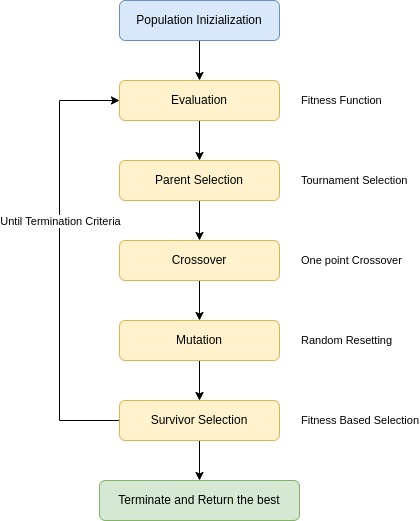

### Initialization


#### Individual

Creating Random Individual

In [ ]:
class Individual():

  def __init__(self, n_points=n_points, height=height, **kwargs):
    self.n_segments = n_points
    self.n_pts = n_points+1
    self.width = 1.0
    self.height = height
    self.y = [self.height]
    self.x = [0]
    self.delta_x = self.width/self.n_segments

    self.sameness_thresh = kwargs.get('sameness_thresh', 1*10.0**(-5))

    self.same_thresh_decay_steps = kwargs.get('same_thresh_decay_steps', None)

    if self.same_thresh_decay_steps is None:
        self.same_thresh_decay_factor = 1.0
    else:
        self.same_thresh_decay_factor = (10.0**-4)**(1.0/self.same_thresh_decay_steps)

    self.mutate_strength_height_frac = kwargs.get('mutate_strength_height_frac', 1/20.0)
    self.mutate_strength = self.height*self.mutate_strength_height_frac
    self.mutate_all_chance = kwargs.get('mutate_all_chance', 0.0)

    for i in range(self.n_segments-1):
        self.x.append((i+1)*self.delta_x)
        frac = 1
        self.y.append(-self.height/frac + random()*(self.height - (-self.height/frac)))

    self.x.append(1.0)
    self.y.append(0)

    self.sol = None

    #This is just assuming it dropping vertically and then going horizonally at that speed
    g = 9.8
    t1 = sqrt(2*self.height/g)
    v1 = g*t1
    t2 = self.width/v1
    self.max_FF = 40*(t1 + t2)

#### Population

Creating a Population with n-random Individuals

In [ ]:
class Population():
  
  def __init__(self, individual_class=Individual, n_population=n_population, **kwargs):
    self.kwargs_str = '__'.join(['{}={}'.format(x[0], x[1]) for x in kwargs.items()])
    print(self.kwargs_str)

    self.individual_class = individual_class
    self.class_name = individual_class.__name__
    self.n_population = n_population
    self.population = [[self.createNewIndivid(**kwargs), 0] for i in range(self.n_population)]
    self.sorted_population = None

    if (show_info):
      self.printPopulation()
      self.plotPopulation()

  def createNewIndivid(self, **kwargs):
    return(self.individual_class(**kwargs))

  def printPopulation(self):
    print("Population Edited Parameters: ")
    print(self.kwargs_str)
    print("--------------------------------")

  def plotPopulation(self,  **kwargs):
    print("Population Diagram: ")
    print("--------------------------------")
    # plot lines
    for individual in self.population:
      plt.plot(individual[0].x, individual[0].y)
    plt.show()


  

### Evaluation

In [ ]:
class Fitness():

  global show_info

  def __init__(self, population=Population, **kwargs):
    self.population = population

  def getBestCurve(self, individual):
    w = individual.width
    h = individual.height

    #The coords we've been using (dropped at (0,h), ending at (w,0)), simply add h to y in the end.

    f_t = lambda t: np.cos(t)-1+ (-h/w)*(np.sin(t)-t)
    t = fsolve(f_t,3.14)[0]

    a = w/(t-sin(t))

    t_range = np.linspace(0,t,individual.n_pts)

    x = lambda t: a*(t-np.sin(t))
    y = lambda t: h + a*(np.cos(t)-1)

    self.sol = (t_range, x, y)

    sol_numeric_y = []

    for x_pt in individual.x:
        f = lambda t: x(t)-x_pt
        tval = fsolve(f,3.14)[0]
        sol_numeric_y.append(y(tval))

    temp_state = individual.y
    individual.y = sol_numeric_y
    individual.sol_numeric_y = sol_numeric_y
    
    self.t_ideal = self.getFitness(individual)
    individual.y = temp_state

    if show_info:
      print('\n-------------------------------------')
      print('Theoretical best time:', self.t_ideal, "\n")

  def getFitness(self, individual):
    g = 9.8

    #So if the next point is lower than the previous one, d will be *positive* (i.e., the y axis is down, opposite with the plot axis.)
    d = -np.array([individual.y[i+1] - individual.y[i] for i in range(individual.n_segments)])

    #Be careful with signs and indices!
    v = sqrt(2*g)*np.sqrt([0] + [sum(d[:(i+1)]) for i in range(len(d))])

    if np.isnan(v).any():
      print('\n\nbad v:',v)
      print('\nbad d sum:',[sum(d[:(i+1)]) for i in range(len(d))])
      print('\nstate', individual.y)
      plt.savefig('test_bad_np.png')
      exit(0)


    #v = np.sqrt([0] + [sum(d[:(i+1)]) for i in range(len(d))])
    v = v[:-1]
    t = (np.sqrt(v**2 + 2*g*d) - v)/(g*d/np.sqrt(d**2 + individual.delta_x**2))

    F1 = (sum(t))
    return F1

  def getFitnessPopulation(self, sort=False):
    for individual in self.population.population:
      individual[1] = self.getFitness(individual[0])

    if sort:
      self.sortIndividuals()

    if show_info:
      self.printFitnessFunctions()

  def sortIndividuals(self):
    list.sort(self.population.population, key=lambda fitness: fitness[1])

  def printFitnessFunctions(self):
    print('\n-------------------------------------')
    print('Objective Fitness 1: ', objectives[0])
    print('\n')
    for index, individual in enumerate(self.population.population):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))

  def plotState(self, individual, ax, width, height, color='black', plot_sol=False, plot_label=False):
    # Pass this an axis from another program. It will handle showing it and stuff.
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title('Comparison Actual Result with Brachistochrone')

    if plot_sol:
      t = self.sol[0]
      x = self.sol[1]
      y = self.sol[2]
      ax.plot(x(t), y(t), '-', color='gray')

      if plot_label:
        ax.text(0.8*width, 0.9*height, 'ideal: {:.3f}'.format(self.t_ideal))

    if plot_label:
      ax.text(0.8*width, 0.8*height, 'cur. best: {:.3f}'.format(self.getFitness(individual)))

    ax.plot(individual.x, individual.y, 'o-', color=color)


  def plotFitnessFunction(self, ax, best, mean):
    ax.clear()
    ax.set_xlabel('Generations')
    ax.set_ylabel('Fitness Function')
    ax.set_title('Best and Mean Results')

    ax.plot(best, label='best', color='dodgerblue')
    ax.plot(mean, label='mean', color='tomato')
    ax.legend()
    ax.text(0.6*len(best), 0.8*max(best), 'best: {:.3f}\nmean: {:.3f}'.format(best[-1], mean[-1]))


### Selection

In [ ]:
class Selection():
  
  def __init__(self, population=Population, **kwargs):
    self.population = population

  def mate(self, other_individ):
    return(self.mateCrossover(other_individ))

  def mateRandomIndices(self, other_individ):
    newindivid_1 = deepcopy(self)
    newindivid_2 = deepcopy(other_individ)
    #inclusive, inclusive
    N_switch = randint(1,self.n_segments-1)
    switch_indices = sample(list(range(1,self.n_segments)),N_switch)

    for index in switch_indices:
      temp = newindivid_1.y[index]
      newindivid_1.y[index] = newindivid_2.y[index]
      newindivid_2.y[index] = temp

    return(newindivid_1,newindivid_2)

  def getBestAndMean(self):
    if self.sorted_population is None:
      return((0,0))

    best = self.sorted_population[0][1]
    mean = sum([individfitness[1] for individfitness in self.sorted_population])/(1.0*len(self.population))
    return((best,mean))

  def isSameState(self, other_state):
    max_diff = ((self.n_pts-2)*self.height)**2
    diff = (np.array(self.y) - np.array(other_state.y))[1:-1]
    abs_diff_normed = abs(sum(diff))/(self.n_pts-2)
    
    if abs_diff_normed < self.sameness_thresh:
      return(True)
    else:
      return(False)

  def deleteDupes(self,pop):
    unique_individs = []
    no_dupes = []
    
    for i,ind1 in enumerate(pop):
      #if ind1.y not in unique_individs:
      is_not_unique = np.any([ind1.isSameState(other) for other in no_dupes])
      if not is_not_unique:
        unique_individs.append(ind1.y)
        no_dupes.append(ind1)

    return(no_dupes)

  def mateTournament(self):
    best_N = max(int(self.n_population/5), 2)
    '''
    # Attention here, check for sortIndividual
    self.sortIndivids()
    '''
    self.population = [x[0] for x in self.sorted_population]
    new_individs = []
    last_ind = min(len(self.population), self.n_population)
    
    for i in range(best_N):
      for j in range(i+1,best_N):
        b1,b2 = self.population[i].mate(self.population[j])
        #b1,b2 = self.mate(self.population[i],self.population[j])
        new_individs.append(b1)
        new_individs.append(b2)

    self.population = (new_individs + self.population)[:self.n_population]
    [individ.mutate() for individ in self.population]


  def mateGrid(self):
    new_individs = []

    #Mating scheme
    last_ind = min(len(self.population),self.n_population)
    for i in range(last_ind):
      for j in range(i+1,last_ind):
        b1,b2 = self.population[i].mate(self.population[j])
        new_individs.append(b1)
        new_individs.append(b2)

    best_individ = deepcopy(self.population[0])
    self.population = self.population + new_individs
    [individ.mutate() for individ in self.population]
    self.population = self.population + [best_individ]
    self.sortIndivids()

    if len(self.sorted_population) > self.n_population:
      self.population = self.deleteDupes([x[0] for x in self.sorted_population])
    else:
      self.population = [x[0] for x in self.sorted_population]

    self.population = self.population[:self.n_population]



### Crossover

In [ ]:
class Crossover():
  
  def mateCrossover(self,other_individ):
    newindivid_1 = deepcopy(self)
    newindivid_2 = deepcopy(other_individ)

    r1 = randint(1,self.n_pts-3)
    r2 = randint(r1+1,self.n_pts-2)

    temp = newindivid_1.y[r1:r2]
    newindivid_1.y[r1:r2] = newindivid_2.y[r1:r2]
    newindivid_2.y[r1:r2] = temp

    return(newindivid_1,newindivid_2)


  def mateAvg(self,other_individ):
    newindivid_1 = deepcopy(self)
    newindivid_2 = deepcopy(other_individ)

    newindivid_1.y = ((np.array(newindivid_1.y) + np.array(newindivid_2.y))/2).tolist()

    return(newindivid_1,newindivid_1)

### Mutation

In [ ]:
class Mutation():
  
  def mutate(self):
    self.sameness_thresh *= self.same_thresh_decay_factor

    if random() < self.mutate_all_chance:
      # Mutate all indices by some amount.
      mut_amount = np.random.normal(scale=self.mutate_strength)
      N_mutate = randint(1, self.n_segments-1)
      mutate_indices = sample(list(range(1, self.n_segments)), N_mutate)

      for index in range(1, self.n_segments-1):
        new_height = self.y[index] + mut_amount
        
        if new_height < self.height:
          self.y[index] = new_height

    else:
      # Mutate random set of indices
      N_mutate = randint(1, self.n_segments-1)
      mutate_indices = sample(list(range(1, self.n_segments)), N_mutate)

      for index in mutate_indices:
        new_height = self.y[index] + np.random.normal(scale=self.mutate_strength)
        if new_height < self.height:
          self.y[index] = new_height

  def mutateSingle(self):
    index = randint(1, self.n_segments-1)
    new_height = self.y[index] + np.random.normal(scale=self.mutate_strength)
    
    if new_height < self.height:
      self.y[index] = new_height

### Survivor Selection

In [ ]:
class Survivor_Selection():

  def solFound(self):
    max_diff = ((self.n_pts-2)*self.height)**2
    diff = np.array(self.y) - np.array(self.sol_numeric_y)
    abs_diff = sum(diff**2)
    thresh = 1*10.0**(-5)
    if abs_diff/max_diff < thresh:
        print('abs_diff/max_diff: {:.3f}'.format(abs_diff/max_diff))
        return(True)
    else:
        return(False)

## Genetic Algorithm execution

In [ ]:
class GeneticAlgorithm():
    
  def __init__(self, population=Population, generations=n_generations):
    self.n_generations = n_generations 

    fitness = Fitness(population)
    fitness.getFitnessPopulation()

    selection = Selection(population)
    
    

    '''
    def plot_evolution(self,  **kwargs):
      N_gen = kwargs.get('N_gen', 550)
      plot_state = kwargs.get('plot_state', True)
      plot_whole_pop = kwargs.get('plot_whole_pop', False)
      save_best_FF = kwargs.get('save_best_FF', True)

      base_name_temp = f'evolve_{self.class_name}__pop={self.n_population}__gen={N_gen}__{self.kwargs_str}__{date_string}'

      if save_gif:
          N_gif_frames = 100
          gif_dir = os.path.join(base_path, "gifs/" + base_name_temp)
          Path(gif_dir).mkdir(parents=True, exist_ok=True)

      if plot_state:
          fig, axes = plt.subplots(2,1,figsize=(6,8))
          ax_FF = axes[0]
          ax_state = axes[1]
      else:
          fig, ax_FF = plt.subplots(1,1,figsize=(8,8))

      if show_info:
          plt.show(block=False)

      sol_found = False

      best = []
      mean = []
      cur_best, cur_mean = 0, 0

      method_list = [func for func in dir(self.individ_class) if callable(getattr(self.individ_class, func))]

      if plot_state and plot_whole_pop:
          NUM_COLORS = self.n_population + 2
          cm = plt.get_cmap('RdBu')
          cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
          scalar_map = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
          pop_plot_color_list = [scalar_map.to_rgba(i) for i in range(NUM_COLORS)][::-1]


      for i in range(self.generations):
          self.sortIndivids()
          cur_best, cur_mean = self.getBestAndMean()

          best.append(cur_best)
          mean.append(cur_mean)

          if i%max(1, int(N_gen/20.0))==0:
              print('Generation {}, current best = {:.3f}, current pop. size = {}'.format(i, cur_best, len(self.population)))

          if 'solFound' in method_list:
              if self.population[0].solFound():
                  print(f'found solution in generation {i}!\n')
                  if 'printState' in method_list:
                      self.population[0].printState()
                  break

          # Plot the current best and mean.
          self.plotFitnessFunction(ax_FF, best, mean)

          # If we're plotting the state of the population, call their plotState() functions.
          # You can plot either the best member, or the whole pop.
          if plot_state:
              ax_state.clear()

              if plot_whole_pop:
                  for j, ind in enumerate(self.population[::-1]):
                      ind.plotState(ax_state, color=pop_plot_color_list[j])

              self.population[0].plotState(ax_state, color='black', plot_sol=True, plot_label=True)

          if show_info:
              fig.canvas.draw()

          if save_gif:
              if i==0 or (i%max(1, int(N_gen/N_gif_frames))==0):
                  plt.savefig(f'{gif_dir}/{i+1}.png')

          self.mateGrid()



      plt.savefig(f'{misc_runs_dir}/{base_name_temp}.png')

      if save_best_FF:
          np.savetxt(f'{misc_runs_dir}/bestFF_{base_name_temp}.txt', best)

      if save_gif:
          # filepaths
          fp_in = misc_runs_dir + "/*.png"
          fp_out = misc_runs_dir + f"/image{counter+1}.gif"
          makeImage(fp_in, fp_out)

      print('\nending mean = {:.3f}'.format(cur_mean))

      return(self.population[0])
    
    #ending_state = pop.plot_evolution(N_gen=self.generations, plot_whole_pop=True, save_gif=True)
'''




# Test Section

## Individual Random Generation

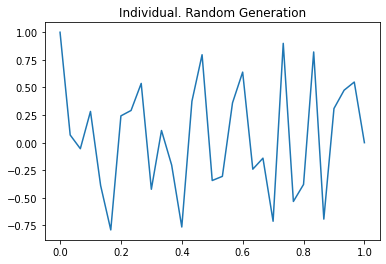


-------------------------------------
Theoretical best time: 0.5844480195427891 

iteration          0     |    loss: 4.9882
iteration         10     |    loss: 1.6155
iteration         20     |    loss: 0.9105
iteration         30     |    loss: 0.7318
iteration         40     |    loss: 0.6736
iteration         50     |    loss: 0.6609
iteration         60     |    loss: 0.6483
iteration         70     |    loss: 0.6409
iteration         80     |    loss: 0.6342
iteration         90     |    loss: 0.6299
iteration        100     |    loss: 0.6225
iteration        110     |    loss: 0.6187
iteration        120     |    loss: 0.6154
iteration        130     |    loss: 0.6118
iteration        140     |    loss: 0.6351
iteration        150     |    loss: 0.6054
iteration        160     |    loss: 0.6043
iteration        170     |    loss: 0.6042
iteration        180     |    loss: 0.6029
iteration        190     |    loss: 0.6007

-------------------------------------


<Figure size 432x288 with 0 Axes>

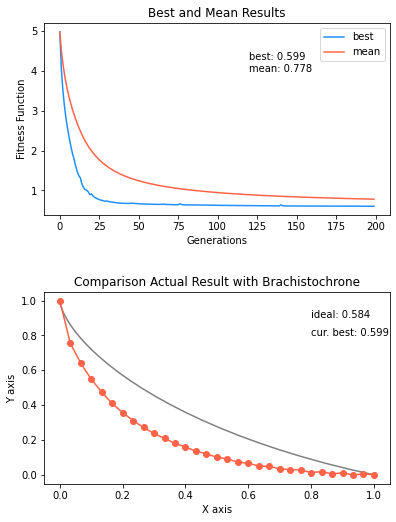

In [ ]:
'''
individual = Individual(n_points=n_points, height=height)
plt.plot(individual.x, individual.y)
plt.title('Individual. Random Generation')
plt.show()

y = torch.tensor(individual.y[1:-1], requires_grad=True)

fitness = Fitness(individual)
fitness.getBestCurve(individual)

adam_optimizer = optim.RMSprop([y])

best = []
mean = []

for t in range(n_generations):

    J = fitnessFunction(y, height)

    best.append(J.item())
    mean.append(np.mean(best))

    individual.y[1:-1] = y.detach().tolist()

    if save_gif:
        if t==0 or (t%max(1, int(n_generations/frames_gif))==0):
            plt.savefig(f'{gif_dir}/{t+1}.png')

    if show_info:
      if t%int(n_generations/20)==0:
        print('iteration {:10}     |    loss: {:.4f}'.format(t, J.item()))

    adam_optimizer.zero_grad()
    J.backward()
    adam_optimizer.step()


plt.savefig(f'{misc_runs_dir}.png')


if show_info:
  print('\n-------------------------------------')

  fig, axes = plt.subplots(2,1,figsize=(6,8))
  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  ax_FF = axes[0]
  ax_state = axes[1]
  fitness.plotFitnessFunction(ax_FF, best, mean)
  fitness.plotState(individual, ax_state, width, height, color='tomato', plot_sol=True, plot_label=True)

  fig.canvas.draw()


if save_gif:
    fp_in = gif_dir + "/*.png"
    fp_out = gif_dir + f'/image{counter+1}.gif'
    makeImage(fp_in, fp_out)

'''


## Population Random Generation

n_points=30__height=1__sameness_thresh=0.15__mutate_strength_height_frac=0.21__same_thresh_decay_steps=200
Population Edited Parameters: 
n_points=30__height=1__sameness_thresh=0.15__mutate_strength_height_frac=0.21__same_thresh_decay_steps=200
--------------------------------
Population Diagram: 
--------------------------------


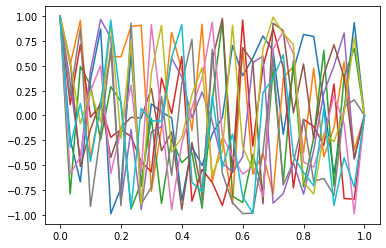


-------------------------------------
Objective Fitness 1:  Short Time


Individual          0     |    Fitness: 4.1898
Individual          1     |    Fitness: 4.4348
Individual          2     |    Fitness: 4.6295
Individual          3     |    Fitness: 4.8268
Individual          4     |    Fitness: 4.9909
Individual          5     |    Fitness: 5.0336
Individual          6     |    Fitness: 5.5400
Individual          7     |    Fitness: 5.8499
Individual          8     |    Fitness: 5.9135
Individual          9     |    Fitness: 5.9602


In [ ]:
population = Population(Individual, n_population, n_points=n_points, height=height, sameness_thresh=15*10**-2, mutate_strength_height_frac=0.21, same_thresh_decay_steps=n_generations)

GeneticAlgorithm(population=population, 
                 generations=n_generations)
